In [1]:
# analyze raster of slopes of whole landscape or of a subbasin.
# Find breakpoints in clusters as marker of changing geomorphic context - e.g valley bottom, valley floor, hillslope

In [2]:
import rioxarray as rxr

In [3]:
slope = rxr.open_rasterio("../working_dir/slope.tif", masked=True).squeeze()

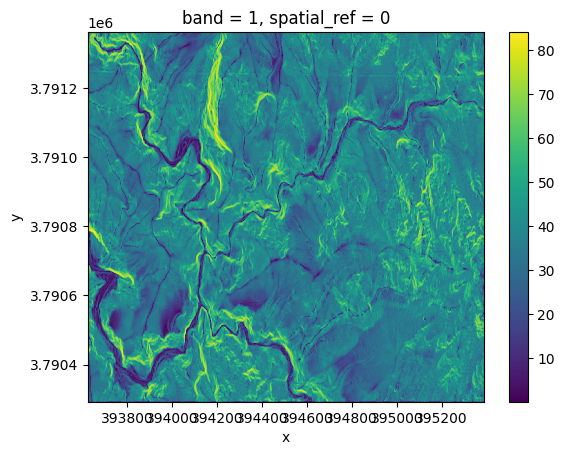

In [4]:
slope.plot()

In [25]:
def analyze_slope_distributions(elevation, distances): # from 2d cross sections
    """
    Use statistical distributions to identify natural breaks in slope patterns.
    """
    from scipy import stats
    
    def calculate_local_slopes(elev, dist, window=5):
        slopes = []
        for i in range(window, len(elev) - window):
            segment = elev[i-window:i+window]
            x = dist[i-window:i+window]
            slope = np.polyfit(x, segment, 1)[0]
            slopes.append(slope)
        return np.array(slopes)
    
    def find_natural_breaks(slopes):
        # Fit Gaussian Mixture Model to find natural slope clusters
        from sklearn.mixture import GaussianMixture
        
        # Reshape for sklearn
        X = slopes.reshape(-1, 1)
        
        # Try different numbers of components
        best_bic = np.inf
        best_n = 2
        for n in range(2, 6):
            gmm = GaussianMixture(n_components=n)
            gmm.fit(X)
            bic = gmm.bic(X)
            if bic < best_bic:
                best_bic = bic
                best_n = n
        
        # Fit final model
        gmm = GaussianMixture(n_components=best_n)
        labels = gmm.fit_predict(X)
        
        return labels, gmm.means_
    
    slopes = calculate_local_slopes(elevation, distances)
    return find_natural_breaks(slopes)

In [23]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np

def fast_cluster_analysis(X, max_clusters=5, batch_size=1000):
    """
    Fast clustering analysis using MiniBatchKMeans and efficient scoring.
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        The data to cluster
    max_clusters : int
        Maximum number of clusters to try
    batch_size : int
        Size of mini-batches
        
    Returns:
    --------
    best_clusters : fitted MiniBatchKMeans
        The best clustering model
    n_clusters : int
        Optimal number of clusters
    """
    # If data is large, take a sample for initial analysis
    max_sample = 10000
    if X.shape[0] > max_sample:
        indices = np.random.choice(X.shape[0], max_sample, replace=False)
        X_sample = X[indices]
    else:
        X_sample = X
        
    # Initialize scoring
    best_score = float('inf')
    best_n = 2
    scores = []
    
    # Try different numbers of clusters
    for n in range(2, max_clusters + 1):
        # Initialize and fit clusterer
        kmeans = MiniBatchKMeans(
            n_clusters=n,
            batch_size=batch_size,
            random_state=42,
            max_iter=100
        )
        kmeans.fit(X_sample)
        
        # Calculate simplified silhouette-like score
        # (faster than full silhouette score)
        inertia = kmeans.inertia_
        separation = compute_cluster_separation(kmeans.cluster_centers_)
        score = inertia / (separation + 1e-10)  # Avoid division by zero
        
        scores.append(score)
        
        if score < best_score:
            best_score = score
            best_n = n
    
    # Final fit with best number of clusters on full data
    final_clusters = MiniBatchKMeans(
        n_clusters=best_n,
        batch_size=batch_size,
        random_state=42
    )
    final_clusters.fit(X)
    
    return final_clusters, best_n

def compute_cluster_separation(centers):
    """
    Compute mean separation between cluster centers.
    """
    n_centers = centers.shape[0]
    if n_centers < 2:
        return 0
        
    separations = []
    for i in range(n_centers):
        for j in range(i + 1, n_centers):
            dist = np.sum((centers[i] - centers[j]) ** 2)
            separations.append(np.sqrt(dist))
            
    return np.mean(separations)

def analyze_regional_slope_distributions(slope_raster, mask=None, window_size=5):
    """Main analysis function with fast clustering"""
    # Your existing feature extraction code here
    features = extract_local_features(slope_raster, window_size)
    
    # Reshape features for clustering
    valid_pixels = ~np.isnan(features[:,:,0])
    X = features[valid_pixels].reshape(-1, features.shape[-1])
    
    # Fast clustering
    clusterer, n_clusters = fast_cluster_analysis(X)
    
    # Create output label raster
    label_raster = np.full(slope_raster.shape, -1)
    label_raster[valid_pixels] = clusterer.labels_
    
    # Compute cluster statistics
    cluster_stats = []
    for i in range(n_clusters):
        mask = clusterer.labels_ == i
        cluster_features = X[mask]
        
        stats = {
            'mean_slope': np.mean(cluster_features[:,0]),  # mean of mean slope
            'std_slope': np.std(cluster_features[:,0]),
            'size': np.sum(mask),
            'proportion': np.sum(mask) / len(clusterer.labels_)
        }
        cluster_stats.append(stats)
    
    # Sort clusters by mean slope
    sorted_idx = np.argsort([stat['mean_slope'] for stat in cluster_stats])
    
    # Calculate break points between sorted clusters
    break_points = []
    centers = clusterer.cluster_centers_[sorted_idx, 0]  # Use first feature (mean slope)
    for i in range(len(centers)-1):
        break_points.append((centers[i] + centers[i+1]) / 2)
    
    return {
        'labels': label_raster,
        'cluster_stats': cluster_stats,
        'break_points': break_points,
        'clusterer': clusterer,
        'features': features
    }

In [25]:
results = analyze_regional_slope_distributions(slope.data)

In [29]:
for cluster in results['cluster_stats']:
    print(cluster['mean_slope'], cluster['std_slope'])

27.053279460696398 3.6374612723622315
43.88774410170212 3.135276649941172
11.654923070347506 5.862050581183115
35.90822716634983 2.5911774649918744
58.321938850762486 6.415335133206238


In [34]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np

def fast_cluster_analysis(X, max_clusters=5, batch_size=1000):
    """
    Fast clustering analysis using MiniBatchKMeans and efficient scoring.
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        The data to cluster
    max_clusters : int
        Maximum number of clusters to try
    batch_size : int
        Size of mini-batches
        
    Returns:
    --------
    best_clusters : fitted MiniBatchKMeans
        The best clustering model
    n_clusters : int
        Optimal number of clusters
    """
    # If data is large, take a sample for initial analysis
    max_sample = 10000
    if X.shape[0] > max_sample:
        indices = np.random.choice(X.shape[0], max_sample, replace=False)
        X_sample = X[indices]
    else:
        X_sample = X
        
    # Initialize scoring
    best_score = float('inf')
    best_n = 2
    scores = []
    
    # Try different numbers of clusters
    for n in range(2, max_clusters + 1):
        # Initialize and fit clusterer
        kmeans = MiniBatchKMeans(
            n_clusters=n,
            batch_size=batch_size,
            random_state=42,
            max_iter=100
        )
        kmeans.fit(X_sample)
        
        # Calculate simplified silhouette-like score
        # (faster than full silhouette score)
        inertia = kmeans.inertia_
        separation = compute_cluster_separation(kmeans.cluster_centers_)
        score = inertia / (separation + 1e-10)  # Avoid division by zero
        
        scores.append(score)
        
        if score < best_score:
            best_score = score
            best_n = n
    
    # Final fit with best number of clusters on full data
    final_clusters = MiniBatchKMeans(
        n_clusters=best_n,
        batch_size=batch_size,
        random_state=42
    )
    final_clusters.fit(X)
    
    return final_clusters, best_n

def compute_cluster_separation(centers):
    """
    Compute mean separation between cluster centers.
    """
    n_centers = centers.shape[0]
    if n_centers < 2:
        return 0
        
    separations = []
    for i in range(n_centers):
        for j in range(i + 1, n_centers):
            dist = np.sum((centers[i] - centers[j]) ** 2)
            separations.append(np.sqrt(dist))
            
    return np.mean(separations)

def analyze_regional_slope_distributions(slope_raster, mask=None, window_size=5):
    """Main analysis function with fast clustering"""
    # Your existing feature extraction code here
    features = extract_local_features(slope_raster, window_size)
    
    # Reshape features for clustering
    valid_pixels = ~np.isnan(features[:,:,0])
    X = features[valid_pixels].reshape(-1, features.shape[-1])
    
    # Fast clustering
    clusterer, n_clusters = fast_cluster_analysis(X)
    
    # Create output label raster
    label_raster = np.full(slope_raster.shape, -1)
    label_raster[valid_pixels] = clusterer.labels_
    
    # Compute cluster statistics
    cluster_stats = []
    for i in range(n_clusters):
        mask = clusterer.labels_ == i
        cluster_features = X[mask]
        
        stats = {
            'mean_slope': np.mean(cluster_features[:,0]),  # mean of mean slope
            'std_slope': np.std(cluster_features[:,0]),
            'size': np.sum(mask),
            'proportion': np.sum(mask) / len(clusterer.labels_)
        }
        cluster_stats.append(stats)
    
    # Sort clusters by mean slope
    sorted_idx = np.argsort([stat['mean_slope'] for stat in cluster_stats])
    
    # Calculate break points between sorted clusters
    break_points = []
    centers = clusterer.cluster_centers_[sorted_idx, 0]  # Use first feature (mean slope)
    for i in range(len(centers)-1):
        break_points.append((centers[i] + centers[i+1]) / 2)
    
    return {
        'labels': label_raster,
        'cluster_stats': cluster_stats,
        'break_points': break_points,
        'clusterer': clusterer,
        'features': features
    }

In [35]:
results = analyze_regional_slope_distributions(slope.data)

In [37]:
import matplotlib.pyplot as plt